# Assignment 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os
import pdb
import os


import sys

# Add the path to utils
sys.path.append('..')
from template import utils

In [2]:
# should be added into a utils file in the future
def set_seed():
    # Set a fixed random seed for reproducibility

    # Set the random seed for PyTorch
    torch.manual_seed(9001)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # If you are using CUDA, set the seed for CUDA as well

    if torch.cuda.is_available():
        torch.cuda.manual_seed(9001)

In [3]:
set_seed()

### Handling the data

In [4]:
# I am a big fan of config files and I believe it is a good practise
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])


config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 20, 'LR': '3e-4'}


In [5]:
# may differ depending on the problem
transform = transforms.Compose(
    [transforms.ToTensor(),
     ]) # put more transforms options here

In [6]:
#load datasets (in the future it's possible that the whole process will be in a 
#separate file)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


Files already downloaded and verified


In [7]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


### We can display some images from the dataset
Functions used will probably vastly differ from task to task

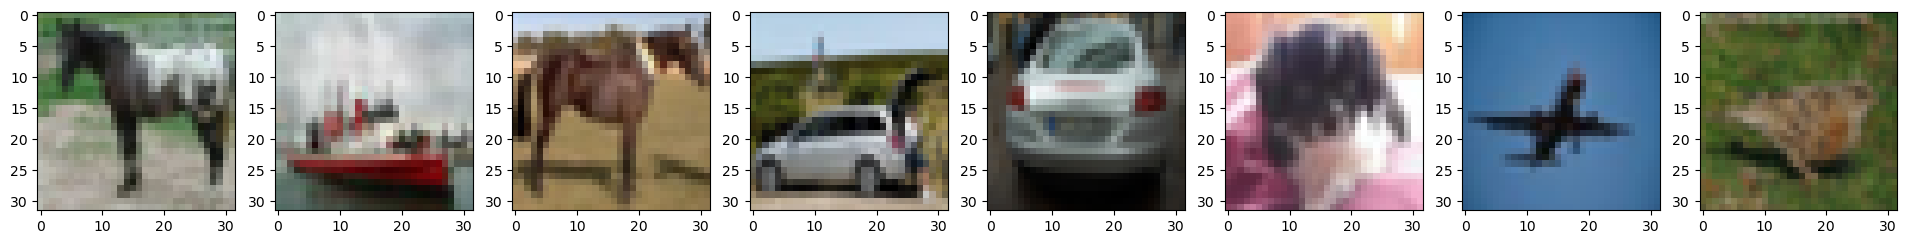

In [9]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,32,32).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

### Creating the model

In [10]:
class CNN(nn.Module):
    """ 
    Adapted to CIFAR-10
    """
    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        # (3,32,32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Layer 2
        # (64, 32, 32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # (64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # (128, 16, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (128, 8, 8)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        # (256, 8, 8)
        
        # fully connected classifier
        in_dim = 256 * 8 * 8
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        out_flat = x.view(cur_b_size, -1)
        y = self.fc(out_flat)
        return y
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Training the model

In [11]:
from tqdm import tqdm

In [12]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training loop

In [15]:
# For saving models and checkpoints later
if(not os.path.exists("models")):
    os.makedirs("models")

In [16]:
test_loss_list = []
train_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    train_loss_list_iter = []
    train_accuracy_list_iter = []
    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100

        train_accuracy_list_iter.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list_iter.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_accuracy_list.append(np.mean(train_accuracy_list_iter))
    train_loss_list.append(np.mean(train_loss_list_iter))

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 8.96%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 59.29%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 65.97%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.31%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.8%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.53%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.6%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.79%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.93%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.58%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.4%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.23%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.03%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.63%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.66%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.48%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.1%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.89%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.89%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.54%


Epoch 20 Iter 782: loss 0.01763. : 100%|██████████| 782/782 [00:03<00:00, 200.82it/s]


evaluating the model

In [17]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 253.79it/s]

Test accuracy: 73.28%


### Visualization: Loss curves and accuracy development

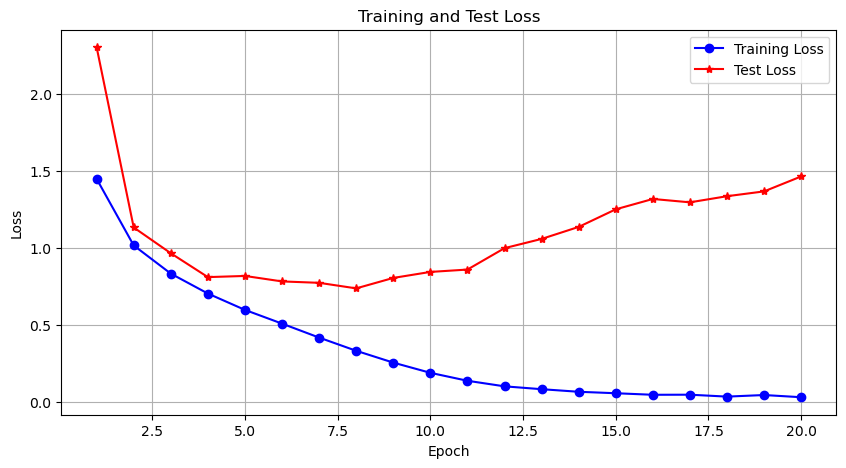

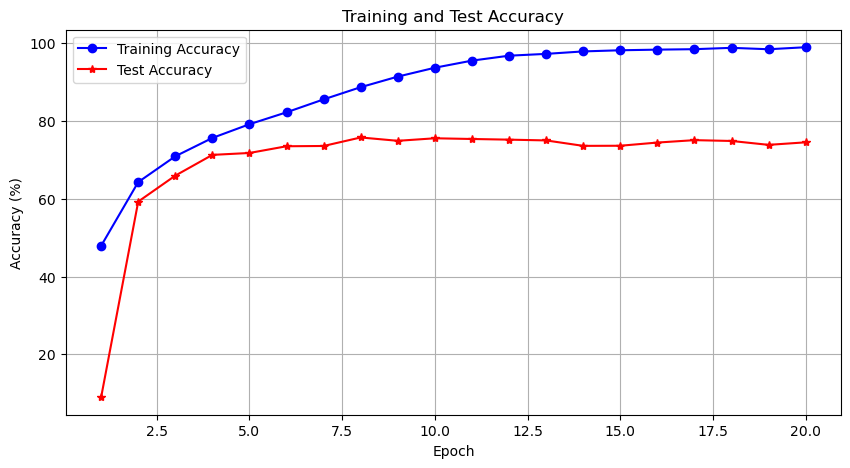

In [18]:
utils.plot_loss_epoch(train_loss_list,  test_loss_list)
utils.plot_accuracy_epoch(test_accuracy_list, train_accuracy=train_accuracy_list)

Training and Test Loss develop as expected. At around epoch 10 the model becomes overconfident in its own predictions, which is why the test loss inceases but the test accuracy stays mostly at the same level

# Evaluation without hyperparameter optimization
Here we achieved an accuracy of 73.1%. We observe a significant increase from the MLP, which achieves an accuracy of around 50%. It is very likely, that the CNN makes better use of the spatial features of an image than the simple MLP. 

Next we want to "somewhat optimize" our hyperparameters using optuna

### Hyperparameter optimization using optuna

In [19]:
import optuna
from optuna.trial import TrialState

In [20]:
class OptCNN(nn.Module):
    def __init__(self, kernel_size1, kernel_size2, kernel_size3, padding1, padding2, padding3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size1, stride=1, padding=padding1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size2, stride=1, padding=padding2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size3, stride=1, padding=padding3)
        self.relu3 = nn.ReLU()
        self.in_dim = 256 * 8 * 8
        self.fc = nn.Linear(in_features=self.in_dim, out_features=10)
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        out_flat = x.view(cur_b_size, -1)
        y = self.fc(out_flat)
        return y
    

In [21]:
def define_model(trial):
    # Suggest hyperparameters to optimize
    kernel_size1 = trial.suggest_categorical('kernel_size1', [3, 5])
    kernel_size2 = trial.suggest_categorical('kernel_size2', [3, 5])
    kernel_size3 = trial.suggest_categorical('kernel_size3', [3, 5])

    # Calculate padding based on kernel sizes
    padding1 = 1 if kernel_size1 == 3 else 2
    padding2 = 1 if kernel_size2 == 3 else 2
    padding3 = 1 if kernel_size3 == 3 else 2

    # Create the CNN model with suggested hyperparameters
    model = OptCNN(kernel_size1, kernel_size2, kernel_size3, padding1, padding2, padding3)
    return model

In [22]:

# Define the objective function for Optuna
def objective(trial):

    # Define the model
    model = define_model(trial)
    model = model.to(device)
    lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Training Loop
    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(trainloader, total=len(trainloader))
        for i, (imgs, labels) in enumerate(progress_bar):

            # using GPU
            imgs, labels = imgs.to(device), labels.to(device)
        
            # forward pass
            preds = model(imgs)

            # calculate accuracy
            with torch.no_grad():
                predicted = preds.argmax(dim=-1)
                correct = (predicted == labels).sum().item()
                accuracy = correct/labels.shape[0]

            train_accuracy_list.append(accuracy)

            # computing error
            loss = criterion(preds, labels)
            train_loss_list.append(loss.item())
            # removing accumulated gradients
            optimizer.zero_grad()
        
            # backprogating error to compute gradients
            loss.backward()
        
            # updating parameters
            optimizer.step()
        
            if(i % 10 == 0 or i == len(trainloader) - 1):
                progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # prune some trials that are doomed to save time
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy



In [23]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")  # maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-03 17:56:07,078] A new study created in memory with name: no-name-e17f9579-2d13-48de-b1f4-6cd4898f715b
/tmp/ipykernel_2852842/789317585.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
Epoch 1 Iter 11: loss 2.23314. :   0%|          | 2/782 [00:00<00:43, 18.06it/s]

Epoch 4 Iter 711: loss 0.51170. :  92%|█████████▏| 718/782 [00:03<00:00, 230.14it/s]
[W 2023-11-03 17:56:20,024] Trial 0 failed with parameters: {'kernel_size1': 5, 'kernel_size2': 3, 'kernel_size3': 3, 'learning_rate': 4.4210358942144625e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2852842/789317585.py", line 39, in objective
    optimizer.step()
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torch/optim/optimizer.py", line 373, in wrapper
    out = func(*args, **kwargs)
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torch/optim/adam.p

KeyboardInterrupt: 

# Dropout

Now we train the model with dropout and check whether we observe any changes. Note, that we added Droputs after Max Pooling layers. Adding Dropouts after convolutional layers appears to be not very popular in the literature. Therefore we opted to add them after the Pooling layers. Disregarding the literature however, one dropout layer after the final convolutional layer achieved positive results, which is why we added one dropout layer after the final convolution. 

In [53]:
class DropoutCNN(nn.Module):
    """ 
    Adapted to CIFAR-10
    """
    def __init__(self, dropout_prob=0.5):
        """ Model initializer """
        super().__init__()
        
        # Layer 1
        # (3,32,32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Layer 2
        # (64, 32, 32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=dropout_prob)

        # (64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # (128, 16, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (128, 8, 8)
        self.dropout2 = nn.Dropout(p=dropout_prob)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)
        # (256, 8, 8)
        
        # Fully connected classifier
        in_dim = 256 * 8 * 8
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        out_flat = x.view(cur_b_size, -1)
        y = self.fc(out_flat)
        return y

In [54]:
model = DropoutCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [55]:
test_loss_list = []
train_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    train_loss_list_iter = []
    train_accuracy_list_iter = []
    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100

        train_accuracy_list_iter.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list_iter.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_accuracy_list.append(np.mean(train_accuracy_list_iter))
    train_loss_list.append(np.mean(train_loss_list_iter))

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 10.07%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 55.79%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 60.96%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 67.44%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 70.06%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 70.97%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.41%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.8%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.95%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 76.11%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.8%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.0%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 76.57%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.24%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 78.2%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 78.18%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.9%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 78.55%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 78.67%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 78.82%


Epoch 20 Iter 782: loss 0.67600. : 100%|██████████| 782/782 [00:04<00:00, 186.07it/s]


### Test accuracy

In [58]:
n_correct = 0
model.eval()
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 217.23it/s]

Test accuracy: 78.88%


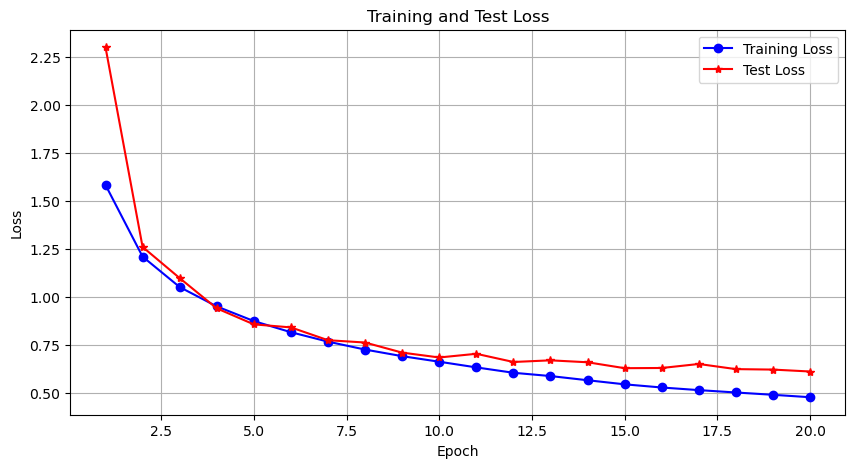

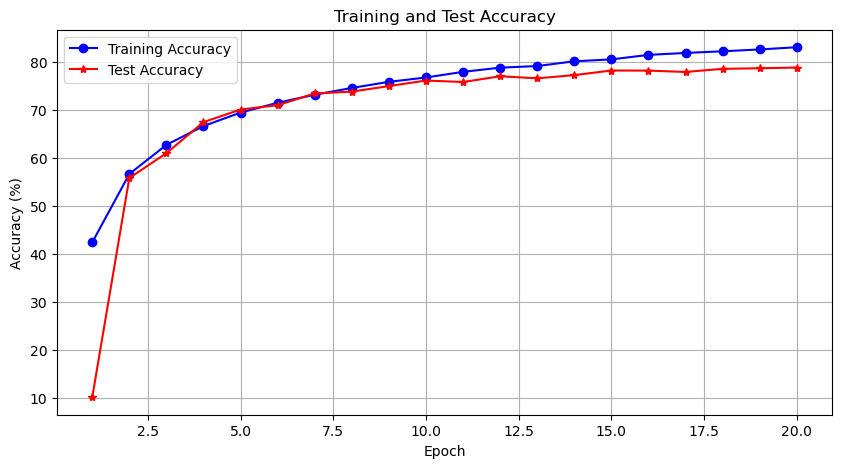

In [57]:
utils.plot_loss_epoch(train_loss_list, test_loss_list)
utils.plot_accuracy_epoch(test_accuracy_list, train_accuracy=train_accuracy_list,)

Looking at out plots, we observe expected results. The test loss is still slightly higher than our training loss. The testing accuracy is slightly below our training accuracy.
Comparing our results to our earlier plots we can see that our model is not overconfident in (wrong) predictions anymore. This is good. Additionally, we observe a 3% increase in accuracy. We do believe a smarter architecture and additional hyperparameteroptimization can improve our reults even further.

# Bonus Task: MLP Mixer


In [30]:

class MLPBlock(nn.Module):
    '''
    Parameters:
         dim: int
         Input and Output dimension of the entire block
         hidden_dim: int
         hidden layer dimension
    '''
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.linear_1 = nn.Linear(dim, hidden_dim)
        self.activation = nn.GELU()
        self.linear_2 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        '''

        :param x: torch.tensor
        Input tensor of shape (batch, n_channels, n_patches)
        :return: torch.tensor, which has the shape (batch, n_channels, n_patches)
        '''
        # print(x.shape)
        x = self.linear_1(x)
        x = self.activation(x)
        x = self.linear_2(x)

        return x


class MixerBlock(nn.Module):
    '''Parameters:
           n_patches : int
           hidden_dim: int
           This was the C value in the paper, the dimension which we project out patches to
           tokens_mlp_dim : int
           Hidden dimension for doing token-mixing
           channels_mlp_dim: int
           Hidden dimension for doing channel mixing
   '''


    def __init__(self, *, n_patches, hidden_dim, token_mlp_dim, channels_mlp_dim):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)

        self.token_mlp_block = MLPBlock(n_patches, token_mlp_dim)
        self.channel_mlp_block = MLPBlock(hidden_dim, channels_mlp_dim)

    def forward(self, x):
        '''
        :param x: torch.Tensor
        It is of shape (batch_size, n_patches, hidden_dim)
        :return: torch. Tensor
        Shape: (batch_size, n_patches, hidden_dim)
        '''
        # Separate y, because we need x as a residual connection
        y = self.norm_1(x)  # (batch, n_patches, hidden_dim)
        # 3d pytorch inputs takes the last dim, i.e. the row, therefore we need to transpose
        y = y.permute(0, 2, 1)  # (batch_size, hidden_dim, n_patches)
        y = self.token_mlp_block(y)  # (batch_size, hidden_dim, n_patches)
        y = y.permute(0, 2, 1)  # (batch_size, n_patches, hidden_dim)
        x = x + y  # (batch_size, n_patches, hidden_dim)
        y = self.norm_2(x)
        res = x + self.channel_mlp_block(y)  # (batch_size, n_patches, hidden_dim)

        return res




class MLPMixer(nn.Module):
    """
    sticking all parts together

    Parameters:
        image_size: int (We assume squares due to us focussing on CIFAR)
            Height and width of the input image
        patch_size: int
            Height and width of the square patches
        tokens_mlp_dim: int
            Hidden Dim for token mixer MLP
        channels_mlp_dim: int
            Hidden dim for MLPBlock when doing the channel mixing
        n_classes : int
            Number of classes for classification
        hidden_dim : int
            dim of patch embeddings
        n_blocks : int
            number of mixerblocks in the architecture
    """

    def __init__(self, *, image_size, patch_size, tokens_mlp_dim, channels_mlp_dim, n_classes, hidden_dim, n_blocks):
        super().__init__()
        n_patches = (image_size // patch_size) ** 2  # assume divisibility

        self.patch_embedder = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)

        self.blocks = nn.ModuleList([MixerBlock(
            n_patches=n_patches,
            hidden_dim = hidden_dim,
            token_mlp_dim=tokens_mlp_dim,
            channels_mlp_dim = channels_mlp_dim
        ) for _ in range(n_blocks)])

        self.pre_head_norm = nn.LayerNorm(hidden_dim)
        self.head_classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        '''Parameters:
        x : torch. Tensor
            Input batch of square images of shape (batch_size, n_channels, image_size, images_size)

        :returns torch. Tensor
            class logits of shape (batch_size, n_classes)
        '''

        x = self.patch_embedder(x) # (batch_size, hidden_dim, n_patches**0.5, n_patches**0.5)
        x = einops.rearrange(x, "n c h w -> n (h w) c") # (batch, n_patches, hidden_dim)


        for mixer_block in self.blocks:
            x = mixer_block(x)  # (batch, n_patches, hidden_dim)


        x = self.pre_head_norm(x)  # (batch_size, n_patches, hidden_dim)
        x = x.mean(dim=1)  # (batch, hidden_dim)
        y = self.head_classifier(x)  # (batch, n_classes)
        return y

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPMixer(image_size=32, patch_size=4, tokens_mlp_dim=2048, channels_mlp_dim=256,
                    n_classes=10, hidden_dim = 512, n_blocks=8)
model = model.to(device)

In [32]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# needed for calculating the patches
import einops

In [33]:
train_loss_list = []
train_accuracy_list = []
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))
    for i, (imgs, labels) in enumerate(progress_bar):

        # Turn model back to training mode
        model.train()

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0]

        train_accuracy_list.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list.append(loss.item())


        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 1 Iter 1: loss 2.31450. :   0%|          | 1/782 [00:00<02:04,  6.29it/s]

Epoch 20 Iter 782: loss 0.02058. : 100%|██████████| 782/782 [00:46<00:00, 16.95it/s]


In [34]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

  3%|▎         | 4/157 [00:00<00:04, 36.59it/s]

100%|██████████| 157/157 [00:03<00:00, 39.49it/s]

Test accuracy: 62.92%


# Evaluation: MLP Mixer

Due to time constraints, we will unfortunately not be able to optimize our hyperparameters further. The ones we used were taken straight from the paper. Due to time constraints we are also not able to pre-train our model.

The MLP Mixer achieved an accuracy of 64.19% on the test set, which was better than the accuracy achieved on the MLP, even after hyperparameter optimization. A reason for this could be the better designed network. It could for instance be possible that, due to the splitting of the images into patches and then connecting the individual patches with each other, we make more use of the spatial information given to us by the data. In addition, we used some simple but more modern techniques like residual connections, which facilitate training of neural networks.

Nevertheless, we do not consider this a complete sucess. We believe, that with sufficient pre-training and hyperparameter optimization higher accuracies can be achieved.